# FOOOF fitting

In [10]:
# Import the FOOOF object
from fooof import FOOOF
import mat73
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # we only use seaborn for smoothing the posteriors with kde

import numpy as np
from scipy import stats

# add the path to the abcTau package
import sys
sys.path.append('./abcTau')
# import the abcTau package
import abcTau
import os

In [7]:
def sort_sig_input(sig, atten_cond):
    ''' This function 1) sorts data to same shape; 2) creates OUT based on out1 and out2
    ------
    sig: data['Full'][layer][atten_cond][epoch] (chs x trials x 1024 timepoints)
    atten_cond: 'RF' or 'OUT'

    Returns
    ------
    sig_in (chs*trials x 1024 timepoints)
    '''
    if len(sig.shape) == 2:
        sig = sig.reshape((1,sig.shape[0],sig.shape[1])) ## sig (channel, trial, timepoints)
    if atten_cond == 'OUT':
        index = np.random.choice(sig.shape[1],int(sig.shape[1]/2))
        sig = sig[:, index, :]
    avg_sig = np.average(sig, axis=1) # average across trials # (channels, timepoints)
    sig_in = sig.reshape((sig.shape[0]*sig.shape[1],sig.shape[2])) -np.repeat(avg_sig, sig.shape[1], axis=0) # average across channels
    #             print(sig_in.shape)
    return sig_in

def comp_psd(x):
    """Compute the power spectrum density (PSD) using a Hamming window and direct fft.
    Parameters
    -----------
    x1 : nd array
        time-series from binned data (numTrials * numBin).
    T : float
        duration of each trial/time-series.
    deltaT : float
        temporal resolution of data (or binSize of spike counts).


    Returns
    -------
    psd : 1d array
        average  power spectrum density (PSD) across all trials.
    """
    n_points = len(x[0])
    x_windowed = (x - x.mean(1)[:, None]) * np.hamming(n_points)
    PSD = np.mean(np.abs(np.fft.rfft(x_windowed)) ** 2, axis=0)[1:-1]

    return PSD

In [141]:
#testdata = pd.read_csv('Subject_Info_V4_test.csv',header=None)
testdata = pd.read_csv('Subject_Info_V4_M1.csv',header=None)
testdata.columns = ['MonkeyId','MonkeyName','SessionId']

In [143]:
datadir = '/Volumes/NONAME/data_for_Yirong'
region = 'V4'
epoch = 'PreFirstDimDataBiZSc'

fs = 1000
T = 1024
deltaT = T / fs 
binSize = T / fs
aperiodic_results = {}
periodic_results = {}
for i in range(len(testdata.loc[testdata.MonkeyId == 1])):
    mid = testdata.iloc[i]['MonkeyId']
    sid = testdata.iloc[i]['SessionId']
    
    ## get data information from csv
    df = pd.read_csv(os.path.join(datadir, 'Subject_Info_corrected.csv'), index_col=0)
    i = df.loc[(df.SessionID == sid) & (df.MonkeyID == mid) & (df.Region == 'V4')].index.values[0]
    monkey_id = int(df.iloc[i]['MonkeyID'])
    monkey_name = df.iloc[i]['MonkeyName']
    region = df.iloc[i]['Region']
    ## load data
    filepath = os.path.join(datadir, 'M%d%s-LFP/%s_%s_LFP_%s_sorted.mat' % (monkey_id, region, monkey_name, region, sid))

    data = mat73.loadmat(filepath)['LfpStruct']['Sorted']
    
    fig = plt.figure(figsize = (30,20))
    i = 0 
    
    for atten_cond in ['RF','OUT']:
        for layer in ['Infra','Granr','Supra']:
            index = 231+i
            ax = plt.subplot(index)
            ## sort data into OUT and RF
            if atten_cond == 'OUT':
                sig1 = sort_sig_input(data['Full'][layer]['OUT1'][epoch], atten_cond)
                sig2 = sort_sig_input(data['Full'][layer]['OUT2'][epoch], atten_cond)
                sig_in = np.concatenate((sig1, sig2), axis=0)
            else:
                sig = data['Full'][layer][atten_cond][epoch]
                sig_in = sort_sig_input(sig, atten_cond)


            data_mean = np.average(np.average(sig_in, axis=1), axis=0)
            data_var = np.average(np.var(sig_in, axis=1), axis=0)
            numTrials = sig_in.shape[0]
            data_sumStat = comp_psd(sig_in)
            f_axis = np.fft.rfftfreq(1024, 1/fs)[1:-1]
            
            # Initialize a FOOOF object
            fm = FOOOF(aperiodic_mode='knee')

            # Set the frequency range to fit the model
            freq_range = [2, 100]

            # Report: fit the model, print the resulting parameters, and plot the reconstruction
            fm.fit(f_axis, data_sumStat, freq_range)
            fm.print_results()

            fk = np.power(fm.aperiodic_params_[1],1/fm.aperiodic_params_[2])
            tau = 1/(2*np.pi*fk)
            aperiodic_results['M%d%s-LFP_%s_%s_%s' % (monkey_id, region, sid, layer, atten_cond)] = np.array([fm.aperiodic_params_[0],fm.aperiodic_params_[1],fm.aperiodic_params_[2],fk,tau])
            periodic_results['M%d%s-LFP_%s_%s_%s' % (monkey_id, region, sid, layer, atten_cond)] = fm.peak_params_
            print('M%d%s_%s_%s_%s'% (monkey_id, region, sid, layer, atten_cond))
            print('fk = %f'%fk)
            print('tau = %f'%tau)
            print('=============')
            
            fm.plot(plot_peaks='shade',ax = ax, plt_log=True)
            ax.set_title('%s_%s'%(layer, atten_cond), fontsize=20)
            
            i = i+1
            #ax.set_title(file_name='M%d%s-LFP_%s_%s_%s' % (monkey_id, region, sid, layer, atten_cond), file_path=os.path.join(datadir,'FOOOF_results'))
            del fm
    
    fig.suptitle('M%d%s-LFP_%s'%(monkey_id, region, sid), fontsize=24)
    fig.savefig(os.path.join(datadir,'FOOOF_results/M%d%s-LFP_%s'%(monkey_id, region, sid)))
    plt.close()


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    6.9960, 1784.7703, 2.9082                                     
                                                                                                  
                                       9 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     6.2781, 127.6101, 2.4570                                     
                                                                                                  
                                       7 peaks were found:                                        
          


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     6.5672, 742.1780, 2.7547                                     
                                                                                                  
                                       3 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.3465, 2835.1635, 3.1681                                     
                                                                                                  
                                       9 peaks were found:                                        
          


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     6.6596, 374.7357, 2.5581                                     
                                                                                                  
                                       8 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.9994, 11332.9612, 3.4608                                    
                                                                                                  
                                       5 peaks were found:                                        
          


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     5.8612, 34.7373, 1.9456                                      
                                                                                                  
                                       9 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.0587, 1491.9448, 2.8280                                     
                                                                                                  
                                       6 peaks were found:                                        
          


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.6141, 6947.6816, 3.0581                                     
                                                                                                  
                                       11 peaks were found:                                       
          


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.4563, 3873.7588, 2.8885                                     
                                                                                                  
                                       6 peaks were found:                                        
          


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.3737, 6377.6577, 2.7714                                     
                                                                                                  
                                       6 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.3185, 5582.6474, 2.8486                                     
                                                                                                  
                                       4 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    6.9314, 3836.3383, 2.7688                                     
                                                                                                  
                                       7 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.4721, 7697.9418, 2.9003                                     
                                                                                                  
                                       10 peaks were found:                                       
          


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    8.1455, 33119.4235, 3.4578                                    
                                                                                                  
                                       15 peaks were found:                                       
          


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    6.9634, 2586.4707, 2.5901                                     
                                                                                                  
                                       8 peaks were found:                                        
          

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    7.0115, 3450.0587, 2.5943                                     
                                                                                                  
                                       6 peaks were found:                                        
          


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.98 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset,

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 100 Hz                        
                                 Frequency Resolution is 0.98 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    8.1718, 60193.7590, 3.3983                                    
                                                                                                  
                                       5 peaks were found:                                        
          

In [144]:
aperiodic_df = pd.DataFrame.from_dict(aperiodic_results,'index',columns=['offset','knee','exponent','fk','tau'])

In [264]:
aperiodic_df[['session','layer','atten_cond']] = np.array([index.split('_') for index in list(aperiodic_results.keys())])[:,1:4]

$$
H_n = \mathcal{N}(\mu_n,\sigma_n), power_n=w_n\\
\therefore E(H) = \int x(\sum_{i=0}^{n}(w_n*p_n(x))dx = \frac{\sum_{i=0}^{n}(w_i*\mu_i)}{\sum_{i=0}^{n}w_i}\\
E(H^2) = \int x^2\sum_{i=0}^{n}(w_n*p_n(x))dx\\
\because E(H_0^2)=\int x^2w_0*p_0(x)dx = w_0(\sigma_0^2+\mu_0^2) \\
\therefore E(H^2) = \frac{\sum_{i=0}^{n}w_i*(\mu_i^2+\sigma_i^2)}{\sum_{i=0}^{n}w_i} \\
Var(H) = E(H^2) - E(H)^2=\frac{\sum_{i=0}^{n}w_i*(\mu_i^2+\sigma_i^2)}{\sum_{i=0}^{n}w_i} - (\frac{\sum_{i=0}^{n}(w_i*(\mu_i^2+\sigma_i^2))}{\sum_{i=0}^{n}w_i})^2\\
$$

In [297]:
def comp_peak_sum(peak_params, boundary):
    index_li0 = set(np.where(peak_params[:,0]>boundary[0])[0])
    index_li1 = set(np.where(peak_params[:,0]<boundary[1])[0])
    
    index_li = list(index_li0 & index_li1)
#     print(np.where(peak_params[:,0]<boundary[1])[0])
#     print(index_li)
    exp_h = np.sum(peak_params[index_li,0]*peak_params[index_li,1])/np.sum(peak_params[index_li,1])
    exp_h2 = np.sum(((peak_params[index_li,0]**2)+(peak_params[index_li,2]**2))*peak_params[index_li,1])/np.sum(peak_params[index_li,1])
    var_h = np.sqrt(exp_h2 - (exp_h**2))
    
    return exp_h, var_h

In [298]:
peak_arr = np.zeros((len(periodic_results),2))
for i,key in enumerate(list(periodic_results.keys())):
    peak_arr[i,0], peak_arr[i,1] = comp_peak_sum(periodic_results[key], [0,50])
    

In [300]:
peak_df = pd.DataFrame(peak_arr,index=list(periodic_results.keys()),columns = ['mu','sigma'])
peak_df[['session','layer','atten_cond']] = np.array([index.split('_') for index in list(periodic_results.keys())])[:,1:4]

In [301]:
def visualize_modelparams(data, layer, var_li,fname):
    fig = plt.figure(figsize = (5*len(var_li),5))
    for i,var in enumerate(var_li):
        stat, p = stats.ttest_rel(data.loc[(data.layer==layer)&(data.atten_cond=='OUT')][var].values,data.loc[(data.layer==layer)&(data.atten_cond=='RF')][var].values)
        ax = plt.subplot(100+i+1+len(var_li)*10)
        sns.violinplot(x="atten_cond", y=var,data=data[data.layer==layer], color='m')
        g = sns.pointplot(data=data[data.layer==layer], x="atten_cond", y=var, hue="session", color=".5")
        plt.setp(g.collections, alpha=.3) #for the markers
        plt.setp(g.lines, alpha=.3)#for the lines
        plt.legend([],[], frameon=False)
        ax.set_title('%s_%s'%(layer,var))
#             annotator.configure(text_format="simple")
#             annotator.set_pvalues_and_annotate(p)
        if p*6<=0.05:
            print('M1_%s_%s_%s p value:%f'%(fname,layer,var, p))
    plt.suptitle('M1_%s'%layer)
    plt.savefig(os.path.join(datadir,'FOOOF_results/M1_%s_%s.png'%(fname, layer)))
    

M1_aperiodic_Infra_fk p value:0.000000
M1_aperiodic_Infra_tau p value:0.003090
M1_aperiodic_Granr_fk p value:0.000000
M1_aperiodic_Granr_tau p value:0.004477
M1_peak_Supra_mu p value:0.003349
M1_aperiodic_Supra_fk p value:0.000000
M1_aperiodic_Supra_tau p value:0.000003


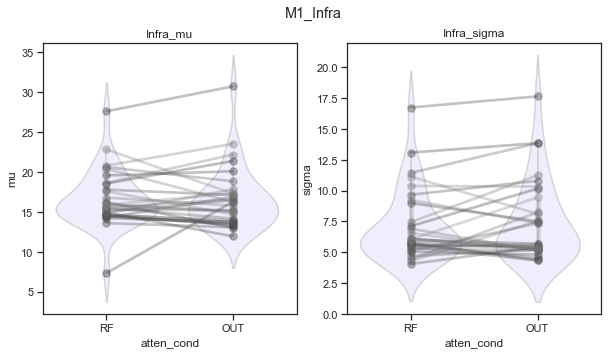

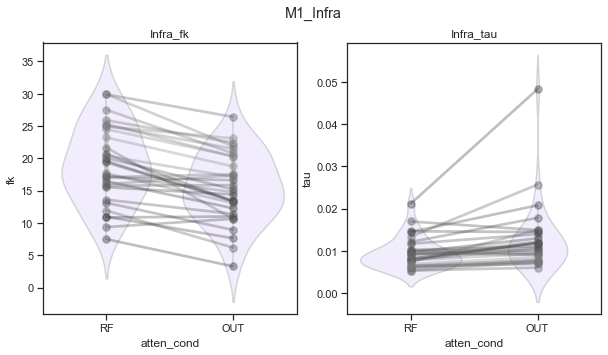

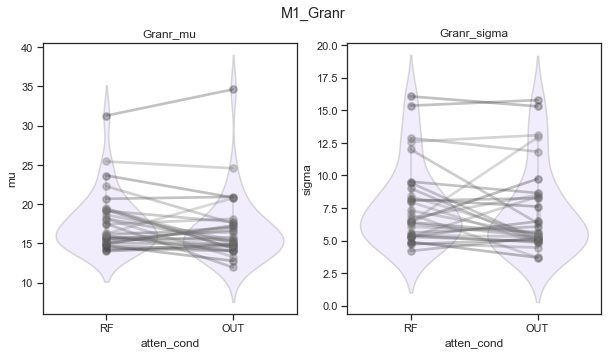

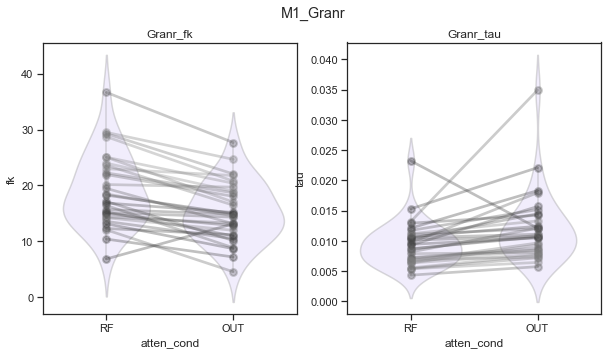

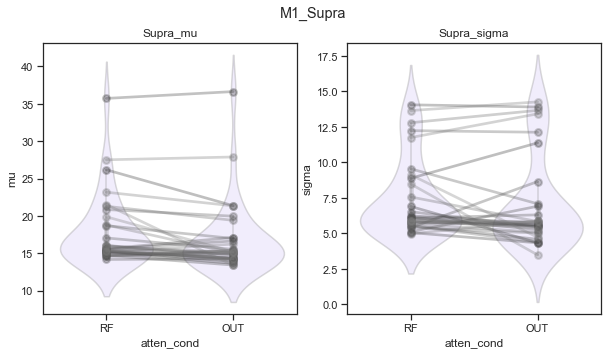

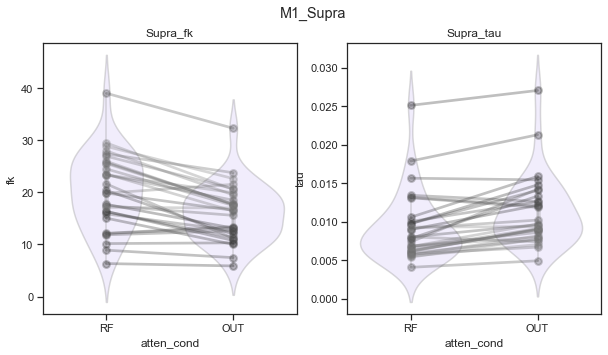

In [302]:
for layer in ['Infra','Granr','Supra']:
    visualize_modelparams(peak_df, layer, ['mu','sigma'],'peak')
    visualize_modelparams(aperiodic_df, layer, ['fk','tau'],'aperiodic')

In [204]:
import scipy.stats as stats
from statannotations.Annotator import Annotator


In [269]:
aperiodic_df.to_csv(os.path.join(datadir,'FOOOF_results/aperiodic_results.csv'))
peak_df.to_csv(os.path.join(datadir,'FOOOF_results/peak_results.csv'))
